In [1]:
import pennylane as qml
import torch
import numpy as np
import random
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

In [2]:
import functools
import inspect
import math
from collections.abc import Iterable
from typing import Callable, Dict, Union, Any

from pennylane import QNode

try:
    import torch
    from torch.nn import Module

    TORCH_IMPORTED = True
except ImportError:
    # The following allows this module to be imported even if PyTorch is not installed. Users
    # will instead see an ImportError when instantiating the TorchLayer.
    from unittest.mock import Mock

    Module = Mock
    TORCH_IMPORTED = False


class TorchLayer(Module):
    def __init__(self,qnode,weights):
        if not TORCH_IMPORTED:
            raise ImportError(
                "TorchLayer requires PyTorch. PyTorch can be installed using:\n"
                "pip install torch\nAlternatively, "
                "visit https://pytorch.org/get-started/locally/ for detailed "
                "instructions."
            )
        super().__init__()

        #weight_shapes = {
        #    weight: (tuple(size) if isinstance(size, Iterable) else () if size == 1 else (size,))
        #    for weight, size in weight_shapes.items()
        #}

        # validate the QNode signature, and convert to a Torch QNode.
        # TODO: update the docstring regarding changes to restrictions when tape mode is default.
        #self._signature_validation(qnode, weight_shapes)
        self.qnode = qnode
        self.qnode.interface = "torch"

        self.qnode_weights = weights

    def forward(self, inputs):  # pylint: disable=arguments-differ
        """Evaluates a forward pass through the QNode based upon input data and the initialized
        weights.

        Args:
            inputs (tensor): data to be processed

        Returns:
            tensor: output data
        """

        if len(inputs.shape) > 1:
            # If the input size is not 1-dimensional, unstack the input along its first dimension,
            # recursively call the forward pass on each of the yielded tensors, and then stack the
            # outputs back into the correct shape
            reconstructor = [self.forward(x) for x in torch.unbind(inputs)]
            return torch.stack(reconstructor)

        # If the input is 1-dimensional, calculate the forward pass as usual
        return self._evaluate_qnode(inputs)


    def _evaluate_qnode(self, x):
        """Evaluates the QNode for a single input datapoint.

        Args:
            x (tensor): the datapoint

        Returns:
            tensor: output datapoint
        """
        kwargs = {
            **{self.input_arg: x},
            **{arg: weight.to(x) for arg, weight in self.qnode_weights.items()},
        }
        res = self.qnode(**kwargs)

        if isinstance(res, torch.Tensor):
            return res.type(x.dtype)

        return torch.hstack(res).type(x.dtype)

    def __str__(self):
        detail = "<Quantum Torch Layer: func={}>"
        return detail.format(self.qnode.func.__name__)

    __repr__ = __str__
    _input_arg = "inputs"

    @property
    def input_arg(self):
        """Name of the argument to be used as the input to the Torch layer. Set to ``"inputs"``."""
        return self._input_arg

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_attention(alpha, img_shape=(8,8), patch_shape=(64,64)):
    """
    alpha: Attention values (torch tensor or numpy array)
    img_shape: Shape of the original image (height, width)
    patch_shape: Shape of the patch (height, width)
    """
    # Reshape alpha to match image shape
    alpha = alpha.detach().numpy() if isinstance(alpha, torch.Tensor) else alpha
    attention_map = np.mean(alpha, axis=0).reshape(patch_shape)  # Mean over the sequence
    
    # Normalize the attention map
    attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min())

    
    # Calculate the sum of each row (goro 합)
    row_sums = np.sum(attention_map, axis=1)
    print("Row sums:", row_sums)

    # Plot the attention map
    plt.figure(figsize=(6, 6))
    sns.heatmap(attention_map, annot=False, cmap="YlGnBu", cbar=True)
    plt.title("Attention Map")
    plt.show()

    # Plot bar chart for the row sums
    plt.figure(figsize=(10, 6))
    plt.bar(np.arange(len(row_sums)), row_sums, color='blue')
    plt.title("Sums of Attention Coefficients by Patch Index")
    plt.xlabel("Patch Index")
    plt.ylabel("Sum of Attention Coefficients")
    
    # Set x-axis ticks to be integers only
    plt.xticks(np.arange(len(row_sums)), np.arange(len(row_sums)).astype(int))
    plt.show()

In [4]:
def set_random_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)

In [5]:
class QSAL_pennylane(torch.nn.Module):
    def __init__(self,S,n,Denc,D):
        super().__init__()
        self.seq_num=S
        self.init_params_Q=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.init_params_K=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.init_params_V=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.num_q=n
        self.Denc=Denc
        self.D=D
        self.d=n*(Denc+2)
        self.dev = qml.device("default.qubit", wires=self.num_q)
        
        self.vqnod=qml.QNode(self.circuit_v, self.dev, interface="torch")
        self.qnod=qml.QNode(self.circuit_qk, self.dev, interface="torch")
        self.weight_v = [{"weights": self.init_params_V[i]} for i in range(self.seq_num)]
        self.weight_q = [{"weights": self.init_params_Q[i]} for i in range(self.seq_num)]
        self.weight_k = [{"weights": self.init_params_K[i]} for i in range(self.seq_num)]
        #self.v_linear ={} #[qml.qnn.TorchLayer(self.vqnod[i], self.weight_shapes) for i in range(self.seq_num)]
        #for i in range(self.seq_num):
        self.v_linear = [TorchLayer(self.vqnod, self.weight_v[i]) for i in range(self.seq_num)]
        self.q_linear = [TorchLayer(self.qnod, self.weight_q[i]) for i in range(self.seq_num)]
        self.k_linear = [TorchLayer(self.qnod, self.weight_k[i]) for i in range(self.seq_num)]
        #self.qqnod=[qml.QNode(self.circuit_qk, self.dev, interface="torch") for i in range(self.seq_num)]
        
        # Add a variable to store the alpha values
        self.alpha = None

    def random_op(self):
        # 무작위 시드 고정
        set_random_seed(42)  # 원하는 시드 값 설정
        a=random.randint(0, 4)
        if a==0:
            op=qml.Identity(0)
        elif a==1:
            op=qml.PauliX(0)
        elif a==2:
            op=qml.PauliY(0)
        else:
            op=qml.PauliZ(0)

        op_elimated=qml.Identity(0)
        for i in range(1,self.num_q):
            op_elimated=op_elimated@qml.Identity(i)
        Select_wrong=True
        while Select_wrong:
            for i in range(1,self.num_q):
                a=random.randint(0, 4)
                if a==0:
                    op=op@qml.Identity(i)
                elif a==1:
                    op=op@qml.PauliX(i)
                elif a==2:
                    op=op@qml.PauliY(i)
                else:
                    op=op@qml.PauliZ(i)
            if op!=op_elimated:
                Select_wrong=False
        return op

    def circuit_v(self,inputs,weights):
            op=self.random_op()
            # feature_map
            indx=0
            for j in range(self.num_q):
                qml.RX(inputs[indx],j)
                qml.RY(inputs[indx+1],j)
                indx+=2
            for i in range(self.Denc):
                for j in range(self.num_q):
                    qml.CNOT(wires=(j,(j+1)%self.num_q))

                for j in range(self.num_q):
                    qml.RY(inputs[indx],j)
                    indx+=1
            # Ansatz
            indx=0
            for j in range(self.num_q):
                qml.RX(weights[indx],j)
                qml.RY(weights[indx+1],j)
                indx+=2
            for i in range(self.D):
                for j in range(self.num_q):
                    qml.CNOT(wires=(j,(j+1)%self.num_q))
                    
                for j in range(self.num_q):
                    #qc.rx(params[indx],j)
                    qml.RY(weights[indx],j)
                    indx+=1
            return [qml.expval(op) for i in range(self.d)] 

    def circuit_qk(self,inputs,weights):
        op=self.random_op()
        # feature_map
        indx=0
        for j in range(self.num_q):
            qml.RX(inputs[indx],j)
            qml.RY(inputs[indx+1],j)
            indx+=2
        for i in range(self.Denc):
            for j in range(self.num_q):
                qml.CNOT(wires=(j,(j+1)%self.num_q))

            for j in range(self.num_q):
                qml.RY(inputs[indx],j)
                indx+=1
        # Ansatz
        indx=0
        for j in range(self.num_q):
            qml.RX(weights[indx],j)
            qml.RY(weights[indx+1],j)
            indx+=2
        for i in range(self.D):
            for j in range(self.num_q):
                qml.CNOT(wires=(j,(j+1)%self.num_q))
                
            for j in range(self.num_q):
                #qc.rx(params[indx],j)
                qml.RY(weights[indx],j)
                indx+=1
        return [qml.expval(qml.PauliZ(0))]

    def forward(self,input):

        Q_output=torch.stack([self.q_linear[i](input[:,i]) for i in range(self.seq_num)])
        K_output=torch.stack([self.k_linear[i](input[:,i]) for i in range(self.seq_num)])
        V_output=torch.stack([self.v_linear[i](input[:,i]) for i in range(self.seq_num)])
    
        Q_output=Q_output.transpose(0,2).repeat((self.seq_num,1,1))
        K_output=K_output.transpose(0,2).repeat((self.seq_num,1,1)).transpose(0,2)

        
        # Calculate alpha and store it in the instance variable
        self.alpha = torch.exp(-(Q_output - K_output)**2).transpose(0, 1)
        # Example usage:
        visualize_attention(self.alpha)
        V_output=V_output.transpose(0,1)
        output=[]
        
        # print("Q_output size:", Q_output.size())
        # print("K_output size:", K_output.size())
        # print("V_output size:", V_output.size())


        for i in range(self.seq_num):
            
            Sum_a=torch.sum(self.alpha[:,i,:],-1)
            div_sum_a=(1/Sum_a).repeat(self.d,self.seq_num,1).transpose(0,2)
            
            Sum_w=torch.sum(self.alpha[:,:,i].repeat((self.d,1,1)).transpose(0,2).transpose(0,1)*V_output*div_sum_a,1)
            output.append(Sum_w)
        return input+torch.stack(output).transpose(0,1)


class QSANN_pennylane(torch.nn.Module):
    def __init__(self,S,n,Denc,D,num_layers):
        """
        # input: input data
        # weight: trainable parameter
        # n: # of of qubits
        # d: embedding dimension which is equal to n(Denc+2)
        # Denc: the # number of layers for encoding 
        # D: the # of layers of variational layers
        # type "K": key, "Q": Query, "V": value
        """
        super().__init__()
        self.qsal_lst=[QSAL_pennylane(S,n,Denc,D) for _ in range(num_layers)]
        self.qnn=nn.Sequential(*self.qsal_lst)

    def forward(self,input):
        return self.qnn(input)

class QSANN_text_classifier(torch.nn.Module):
    def __init__(self,S,n,Denc,D,num_layers):
        """
        # input: input data
        # weight: trainable parameter
        # n: # of of qubits
        # d: embedding dimension which is equal to n(Denc+2)
        # Denc: the # number of layers for encoding 
        # D: the # of layers of variational layers
        # type "K": key, "Q": Query, "V": value
        """
        super().__init__()
        self.Qnn=QSANN_pennylane(S,n,Denc,D,num_layers)
        self.final_layer=nn.Linear(n*(Denc+2)*S, 3)
        self.final_layer=self.final_layer.float()

    def forward(self,input):
        print(input.shape)
        x=self.Qnn(input)
        x=torch.flatten(x,start_dim=1)
        # print('done2')
        output = torch.sigmoid(self.final_layer(x))
        # print('done3')
        return output

In [6]:
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# CIFAR-10 데이터 불러오기
(X_train_full, y_train_full), (X_test_full, y_test_full) = cifar10.load_data()

# 데이터 정규화 (0-255 값을 0-1 사이로)
X_train_full = X_train_full.astype('float32') / 255.0
X_test_full = X_test_full.astype('float32') / 255.0

# RGB -> Grayscale 변환
# 공식: 0.299*R + 0.587*G + 0.114*B
X_train_gray = np.dot(X_train_full[...,:3], [0.299, 0.587, 0.114])
X_test_gray = np.dot(X_test_full[...,:3], [0.299, 0.587, 0.114])

# 원하는 두 개의 클래스만 선택 (예: 클래스 0과 1)
selected_classes = [0, 1, 2]

# 클래스 0과 1에 해당하는 데이터만 선택 (train set)
train_mask = np.isin(y_train_full, selected_classes)
X_train_filtered = X_train_gray[train_mask.squeeze()]
y_train_filtered = y_train_full[train_mask.squeeze()]

# # 클래스 0과 1에 해당하는 데이터만 선택 (test set)
# test_mask = np.isin(y_test_full, selected_classes)
# X_test_filtered = X_test_gray[test_mask.squeeze()]
# y_test_filtered = y_test_full[test_mask.squeeze()]


# 시드 고정
np.random.seed(42)

# 2000개의 데이터를 무작위로 선택
num_samples = 300
indices = np.random.choice(len(X_train_filtered), num_samples, replace=False)
X_sampled, y_sampled = X_train_filtered[indices], y_train_filtered[indices]

# 2000개의 샘플에서 train/test 데이터 분할 (80% train, 20% test 비율로 나눔)
X_train, X_test, y_train, y_test = train_test_split(
    X_sampled, y_sampled, stratify=y_sampled, test_size=0.2, random_state=42
)

y_train = y_train.squeeze(1)
y_test = y_test.squeeze(1)


y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

# 결과 출력
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Sampled train labels: {np.unique(y_train)}")
print(f"Sampled test labels: {np.unique(y_test)}")


2024-11-28 16:19:39.405940: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-28 16:19:39.425631: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-28 16:19:39.449997: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-28 16:19:39.457456: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 16:19:39.481190: I tensorflow/core/platform/cpu_feature_guar

Training set size: 240
Test set size: 60
Sampled train labels: [0. 1.]
Sampled test labels: [0. 1.]


In [7]:
X_train.shape

(240, 32, 32)

In [8]:
# 2x2 크기로 겹치지 않게 패치로 나누는 함수
def split_into_non_overlapping_patches(image, patch_size=(4, 4)):
    patches = []
    for i in range(0, image.shape[0], patch_size[0]):
        for j in range(0, image.shape[1], patch_size[1]):
            patch = image[i:i+patch_size[0], j:j+patch_size[1]].flatten()
            patches.append(patch)
    return np.array(patches)

In [9]:
# 각 이미지를 2x2 겹치지 않는 패치로 나누기
X_train = np.array([split_into_non_overlapping_patches(img) for img in X_train])
X_test = np.array([split_into_non_overlapping_patches(img) for img in X_test])

In [10]:
# y_train이 numpy 배열일 경우
unique, counts = np.unique(y_sampled, return_counts=True)
class_distribution = dict(zip(unique, counts))
print(class_distribution)

{0: 100, 1: 100, 2: 100}


In [11]:
# Model, optimizer, and criterion setup
model = QSANN_text_classifier(64, 4, 2, 1, 1)
optimizer = torch.optim.Adam(lr=0.01, params=model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [12]:
# Print out the parameters and their shapes
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Parameter name: {name}")
        print(f"Shape: {param.shape}")
        print(f"Number of parameters: {param.numel()}")
        print("-" * 50)

# Total number of parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")


Parameter name: Qnn.qnn.0.init_params_Q
Shape: torch.Size([64, 12])
Number of parameters: 768
--------------------------------------------------
Parameter name: Qnn.qnn.0.init_params_K
Shape: torch.Size([64, 12])
Number of parameters: 768
--------------------------------------------------
Parameter name: Qnn.qnn.0.init_params_V
Shape: torch.Size([64, 12])
Number of parameters: 768
--------------------------------------------------
Parameter name: final_layer.weight
Shape: torch.Size([3, 1024])
Number of parameters: 3072
--------------------------------------------------
Parameter name: final_layer.bias
Shape: torch.Size([3])
Number of parameters: 3
--------------------------------------------------
Total number of trainable parameters: 5379


torch.Size([2, 64, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


Row sums: [57.920204 58.93744  54.11956  58.587    47.84775  59.152515 58.3208
 53.08068  42.617573 56.19997  55.088665 49.65336  44.278248 53.959064
 45.1521   58.19487  54.84252  58.95513  54.45774  51.175373 55.250336
 48.023785 56.735985 57.426228 57.272827 57.179867 53.16815  57.696033
 47.868057 52.462955 59.67524  58.729797 57.0712   59.00222  54.375027
 53.697464 59.38725  52.054478 52.61901  51.88176  52.535667 58.202293
 56.952553 56.148712 54.255035 53.314255 57.701057 57.21766  55.932686
 53.362755 46.126804 57.447754 58.21903  52.904736 58.536118 38.72833
 58.733456 40.820198 56.09404  59.715958 50.607132 56.081017 58.156208
 57.062176]


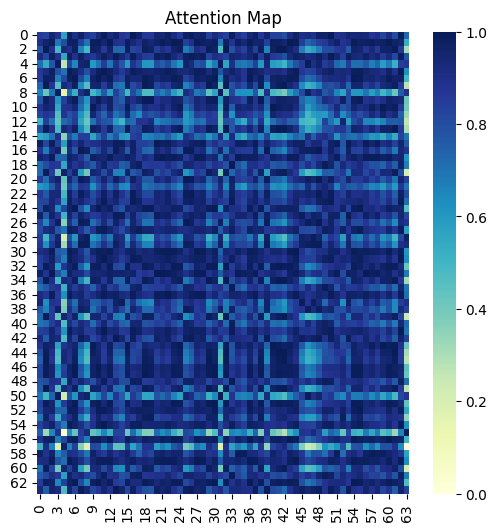

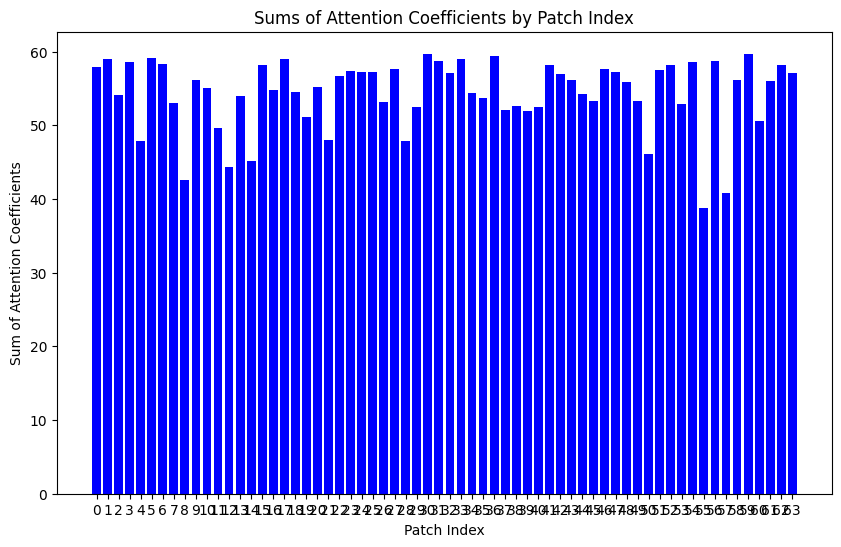

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
    QSAL_pennylane-1               [-1, 64, 16]               0
   QSANN_pennylane-2               [-1, 64, 16]               0
            Linear-3                    [-1, 3]           3,075
Total params: 3,075
Trainable params: 3,075
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.01
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [13]:
from torchsummary import summary
summary(model, input_size=(64, 16))  # (sequence_length, embed_size)


In [13]:
def multi_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    pred_soft = torch.log_softmax(preds, dim=1)
    _, pred_index = torch.max(pred_soft, dim=1)
    print(pred_index)
    y = [int(w.argmax()) for w in y]
    y = torch.tensor(y, dtype=float)
    print(y)
    correct_pred = (pred_index == y).float()
    #round predictions to the closest integer
    
    acc = correct_pred.sum()/len(correct_pred)

    return acc

  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([240, 64, 16])
Row sums: [55.445374 54.067005 57.543243 57.130875 57.943855 53.3553   58.2705
 58.0913   56.753944 57.88034  58.50956  48.929207 53.753998 58.238407
 56.978477 56.381973 44.560303 56.526234 51.323315 56.41033  52.590103
 54.933495 52.233433 57.317055 57.723763 57.152763 56.85974  55.388252
 55.265423 41.40474  57.630974 54.20063  57.34271  56.026665 48.12769
 53.36856  46.669647 55.828827 47.665222 56.124336 40.96658  55.957928
 50.505196 56.92514  57.422726 54.714912 58.089993 56.90425  55.11924
 40.325237 53.03834  55.959084 39.69876  49.049812 56.60556  56.896297
 55.995132 57.091232 57.844063 48.008984 54.247017 48.677803 53.3219
 58.379303]


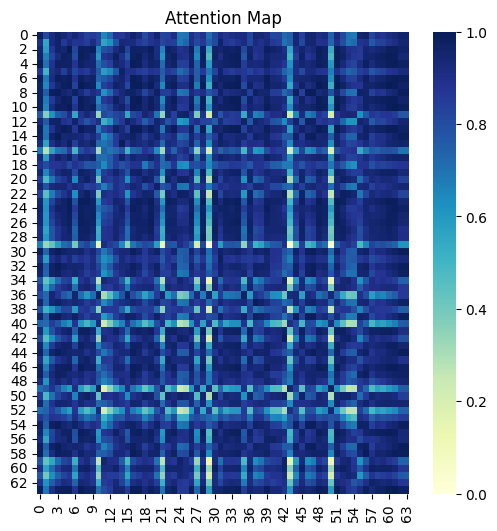

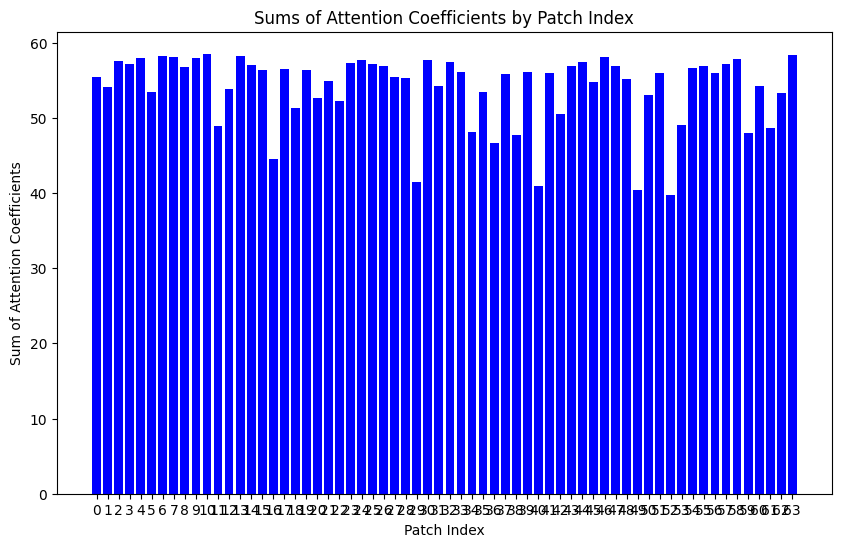

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  2%|▏         | 1/50 [23:13<18:58:11, 1393.71s/it]

torch.Size([240, 64, 16])
Row sums: [55.08811  53.58423  57.412636 57.251713 57.812336 52.842617 58.154564
 57.866203 56.73533  57.898235 58.392902 48.869205 53.45037  58.19832
 56.59259  56.125328 44.972588 56.22503  51.094826 56.410324 52.1284
 54.876633 52.642574 57.41435  57.565163 56.962288 56.617218 55.632282
 55.190212 41.652588 57.45233  53.792145 57.25524  56.098007 48.04647
 53.410484 45.692924 55.769547 47.689774 55.705948 40.200798 56.136536
 50.355373 56.7874   57.20337  54.82312  57.951225 56.60457  55.160305
 39.1519   53.358055 55.843533 39.565567 48.36538  56.164894 56.656013
 55.888878 57.127853 57.5804   47.945236 54.41268  49.046463 53.097572
 58.312004]


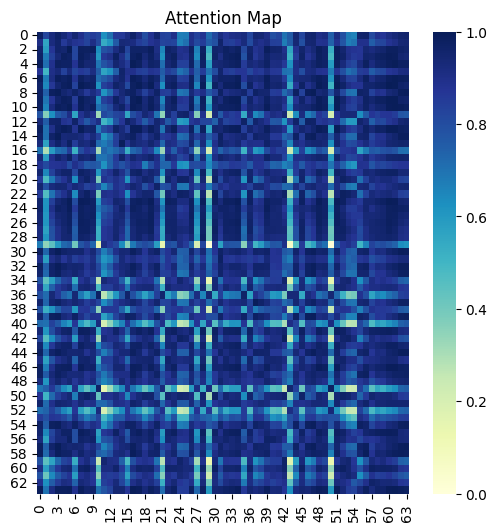

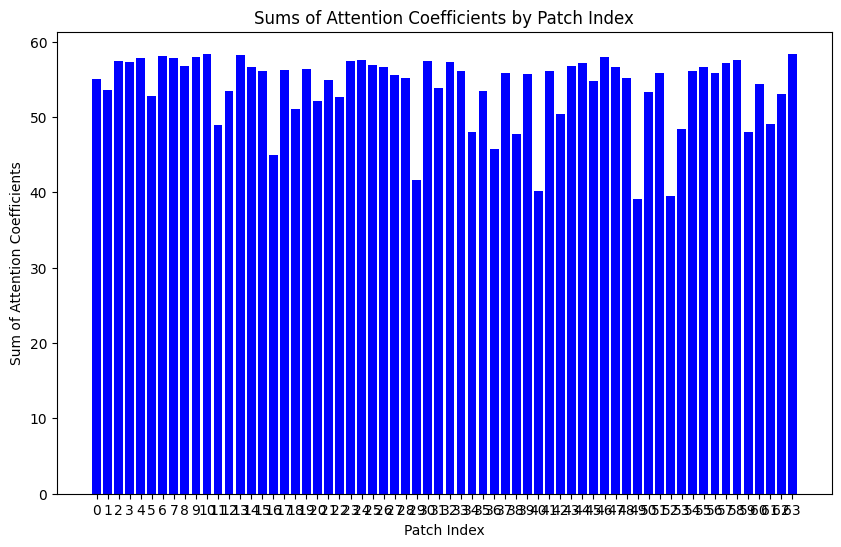

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

  4%|▍         | 2/50 [49:04<19:49:01, 1486.27s/it]

torch.Size([240, 64, 16])
Row sums: [54.91169  53.40911  57.47388  57.476368 57.824265 52.53833  58.117584
 57.78602  56.75596  57.993065 58.40178  49.04209  53.28975  58.256447
 56.37317  56.1064   45.5318   56.10801  51.071148 56.521748 51.920956
 54.991966 53.15645  57.625324 57.543888 56.941414 56.494835 55.845848
 55.196304 41.58793  57.354572 53.660847 57.155098 56.30519  48.41403
 53.700695 45.23771  55.90923  47.835266 55.768627 40.16491  56.403748
 50.415604 56.88146  57.23947  54.772427 57.95038  56.47997  55.19335
 39.67151  53.52801  55.97596  39.237934 48.246376 56.315224 56.691193
 55.7985   57.282215 57.455235 47.887684 54.616882 49.664448 53.20085
 58.34014 ]


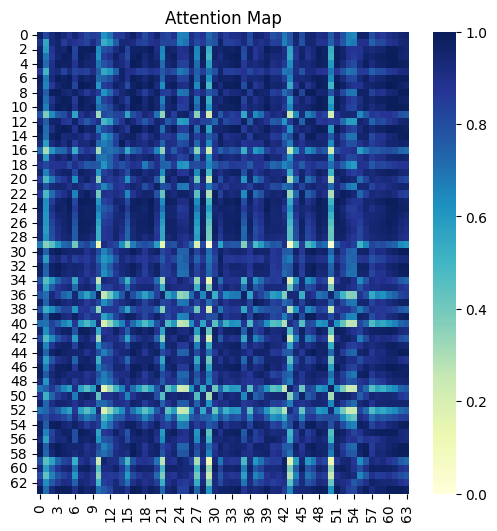

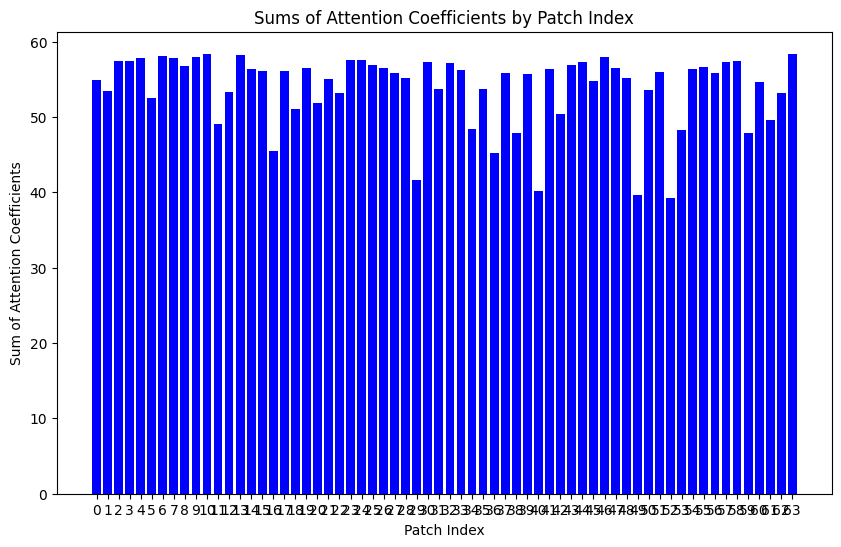

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

  6%|▌         | 3/50 [1:16:17<20:16:33, 1553.05s/it]

torch.Size([240, 64, 16])
Row sums: [54.74182  53.28027  57.503494 57.611618 57.80632  52.234352 58.100624
 57.639004 56.73574  58.03997  58.375343 48.80357  53.182014 58.269547
 56.201843 56.067795 45.608063 55.958927 50.92801  56.52156  51.56125
 55.05993  53.533245 57.758312 57.488327 56.85407  56.297104 55.883877
 55.107407 41.196297 57.2744   53.504242 57.124683 56.26288  48.658356
 53.894485 44.99672  56.038063 47.920593 55.813282 40.59097  56.58792
 50.315666 56.92649  57.21753  54.653576 57.89703  56.382    55.174034
 40.288692 53.650276 56.060764 38.982952 48.029636 56.42651  56.774666
 55.628    57.31856  57.268562 47.89214  54.72989  50.116554 53.238174
 58.32113 ]


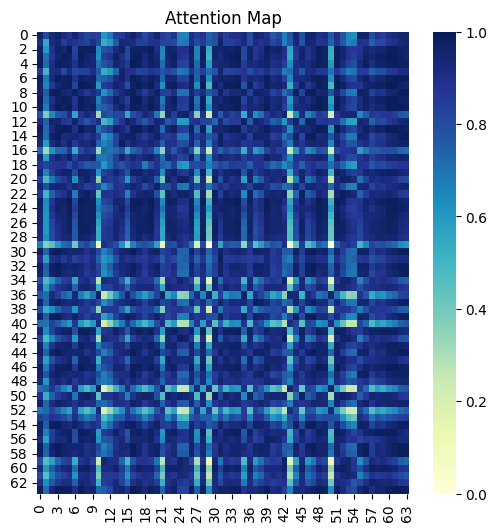

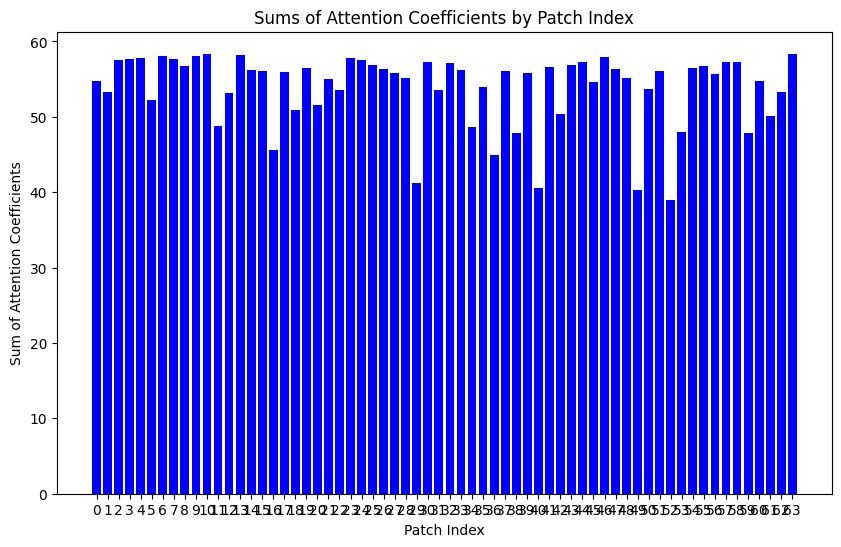

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

  8%|▊         | 4/50 [1:43:56<20:22:53, 1595.08s/it]

torch.Size([240, 64, 16])
Row sums: [54.62404  53.3525   57.55262  57.74788  57.813206 52.010117 58.107746
 57.49228  56.75866  58.102085 58.364334 48.565742 53.171455 58.29161
 56.09468  56.062943 45.54653  55.8575   50.89401  56.53926  51.320415
 55.15897  53.88774  57.890953 57.45912  56.789948 56.108734 55.874466
 55.116577 40.856586 57.25004  53.408524 57.181713 56.200233 48.980045
 54.129364 45.0456   56.22186  48.11175  55.870773 41.291435 56.78044
 50.29967  56.993088 57.188408 54.622036 57.85635  56.3882   55.182735
 41.14292  53.850475 56.183346 39.049004 47.90298  56.564056 56.883522
 55.480644 57.339058 57.07711  48.067665 54.879463 50.604683 53.36765
 58.307495]


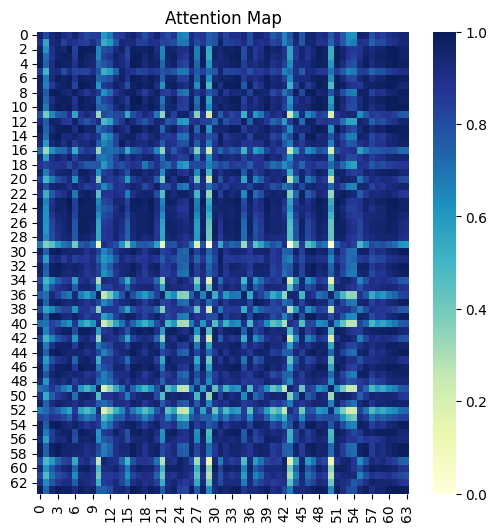

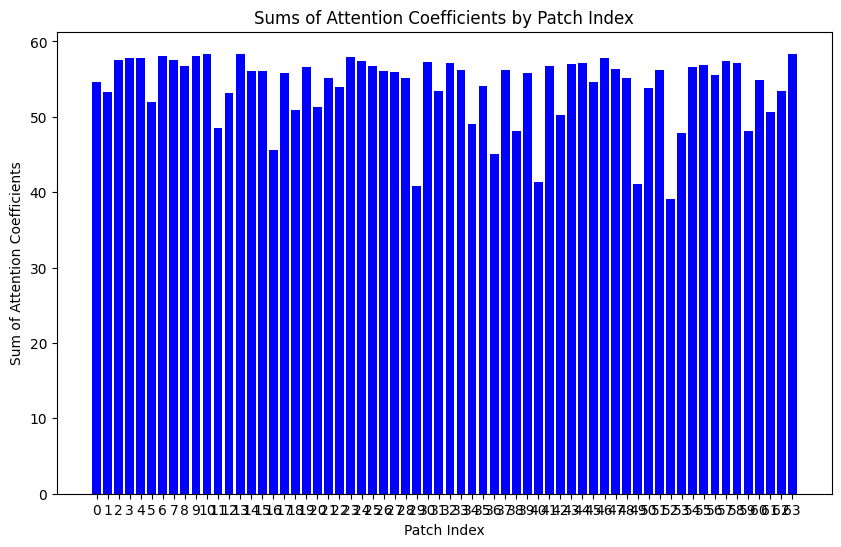

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 10%|█         | 5/50 [2:11:47<20:16:44, 1622.33s/it]

torch.Size([240, 64, 16])
Row sums: [54.566063 53.552067 57.630463 57.896523 57.8511   51.869934 58.143402
 57.357685 56.819176 58.18123  58.379456 48.34816  53.253227 58.33429
 56.054703 56.098595 45.488754 55.806343 50.94321  56.581493 51.172688
 55.287968 54.23822  58.034035 57.464863 56.756454 55.937916 55.839592
 55.196487 40.590816 57.27743  53.37743  57.316353 56.15033  49.364876
 54.40552  45.33251  56.453335 48.402985 55.952095 42.187614 56.992226
 50.37965  57.08833  57.19001  54.704735 57.837227 56.493805 55.219597
 42.174885 54.142174 56.341244 39.394173 47.987198 56.7333   57.02269
 55.36763  57.35213  56.895134 48.373714 55.070633 51.12894  53.576942
 58.31073 ]


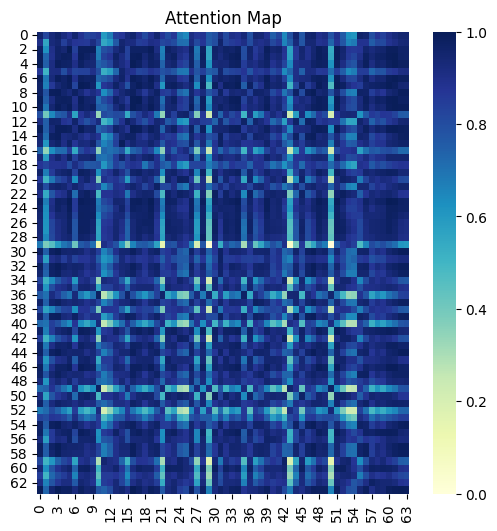

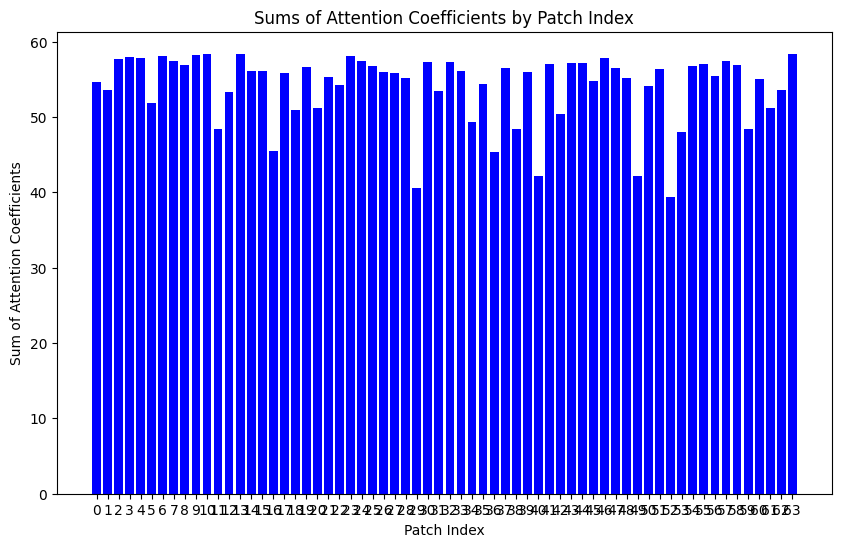

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 12%|█▏        | 6/50 [2:40:03<20:08:02, 1647.34s/it]

torch.Size([240, 64, 16])
Row sums: [54.534187 53.776253 57.717472 58.03749  57.896236 51.764717 58.18606
 57.212547 56.873344 58.254547 58.402702 48.11894  53.38197  58.379097
 56.05578  56.145576 45.39722  55.7667   50.977737 56.610023 51.0234
 55.40203  54.5738   58.168785 57.47989  56.72395  55.7558   55.75791
 55.269283 40.299286 57.320984 53.367184 57.487812 56.090958 49.736637
 54.677555 45.762672 56.692593 48.723045 56.031387 43.12742  57.1971
 50.50189  57.186245 57.217316 54.87024  57.814075 56.660072 55.243855
 43.249054 54.467445 56.493294 39.89722  48.21383  56.904793 57.166565
 55.257942 57.331627 56.69976  48.749    55.265884 51.632584 53.810257
 58.313866]


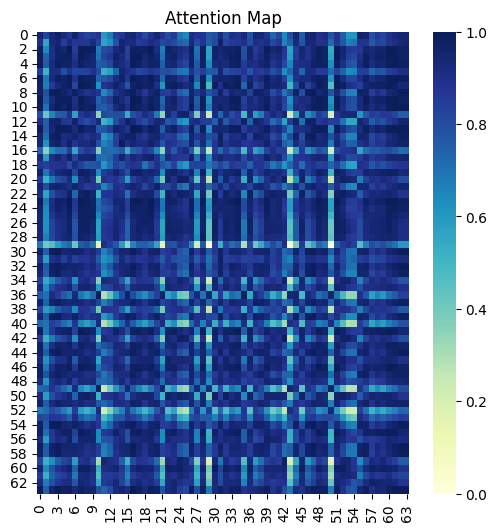

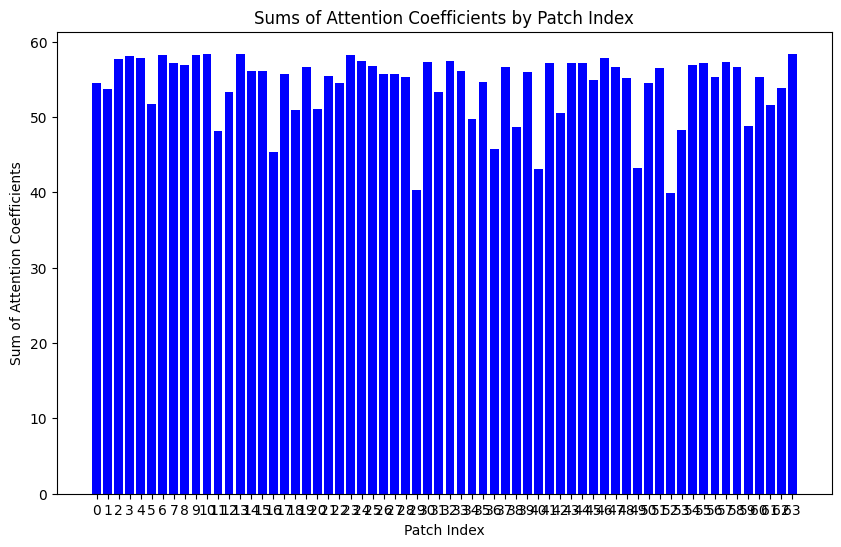

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 14%|█▍        | 7/50 [3:08:30<19:54:38, 1666.95s/it]

torch.Size([240, 64, 16])
Row sums: [54.503773 54.016903 57.79446  58.156784 57.93274  51.67035  58.20724
 57.04227  56.917706 58.30816  58.419228 47.841938 53.523888 58.412704
 56.064888 56.18344  45.265934 55.719612 51.003326 56.61581  50.882828
 55.50027  54.860077 58.281292 57.490013 56.67617  55.544533 55.63575
 55.35312  39.988804 57.360847 53.35228  57.660942 56.02971  50.078026
 54.929596 46.253693 56.923737 49.025375 56.0991   44.071136 57.379578
 50.630257 57.27111  57.27236  55.06073  57.77984  56.844826 55.235092
 44.324158 54.793983 56.63189  40.477997 48.460327 57.072617 57.29377
 55.131866 57.288704 56.481556 49.10933  55.44228  52.094986 54.040115
 58.302605]


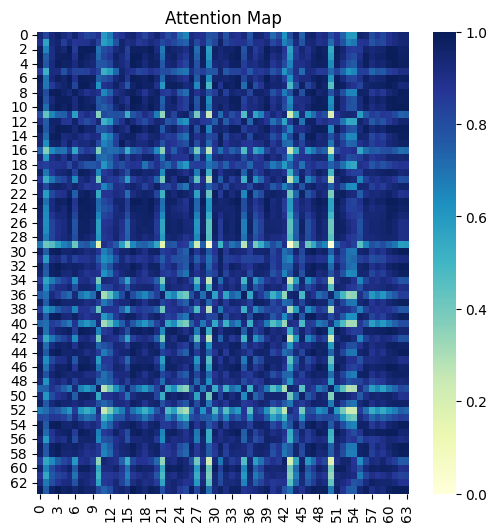

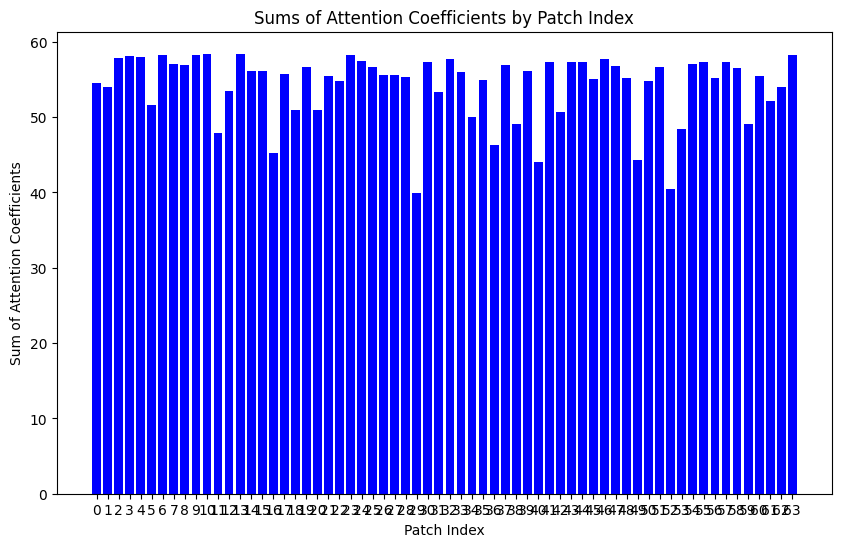

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 16%|█▌        | 8/50 [3:37:01<19:36:39, 1680.95s/it]

torch.Size([240, 64, 16])
Row sums: [54.46852  54.248848 57.856476 58.251717 57.957176 51.57602  58.200245
 56.843494 56.94773  58.339005 58.426147 47.516136 53.665337 58.43341
 56.072132 56.20594  45.08802  55.655624 51.014114 56.59288  50.741905
 55.583942 55.09365  58.36995  57.48796  56.605953 55.29827  55.47529
 55.449738 39.667267 57.389465 53.32275  57.822025 55.976845 50.380142
 55.155098 46.769226 57.138702 49.282143 56.154728 44.987164 57.53485
 50.74142  57.338974 57.357395 55.25305  57.73693  57.030296 55.183537
 45.37388  55.10452  56.75559  41.090584 48.696503 57.23619  57.398884
 54.981804 57.22682  56.2406   49.419403 55.590126 52.507385 54.254654
 58.27433 ]


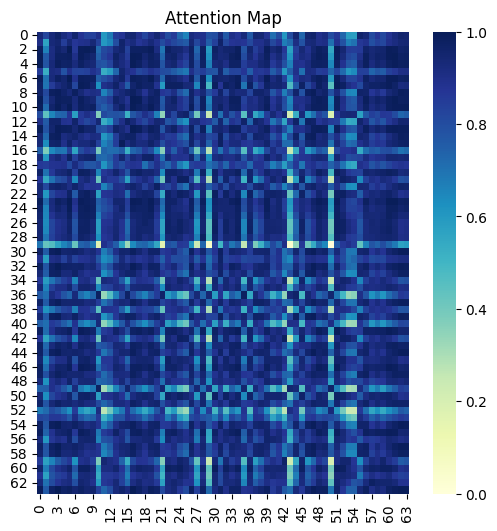

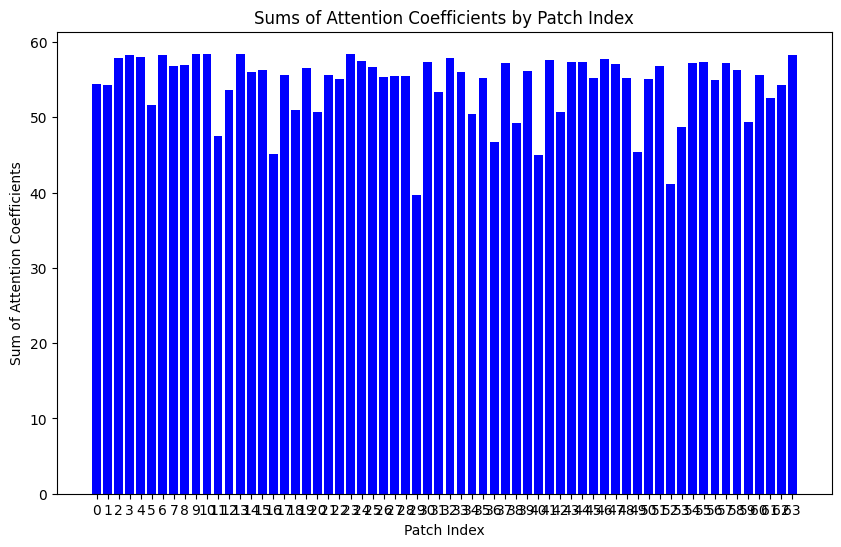

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 18%|█▊        | 9/50 [4:06:28<19:27:00, 1707.81s/it]

torch.Size([240, 64, 16])
Row sums: [54.437634 54.4638   57.91385  58.33196  57.97706  51.493027 58.171204
 56.619102 56.963997 58.355473 58.43089  47.16776  53.82035  58.448837
 56.09266  56.22303  44.883934 55.58033  51.02362  56.543495 50.59559
 55.65668  55.30679  58.444836 57.47638  56.517197 55.023804 55.283073
 55.53616  39.329506 57.411087 53.28849  57.975525 55.941048 50.654743
 55.362022 47.335617 57.34271  49.525566 56.207703 45.891823 57.674603
 50.849274 57.398804 57.470146 55.44821  57.69165  57.21926  55.095127
 46.408165 55.40187  56.869316 41.768787 48.99769  57.401115 57.493385
 54.818924 57.150993 55.9843   49.71784  55.7242   52.88662  54.461487
 58.237732]


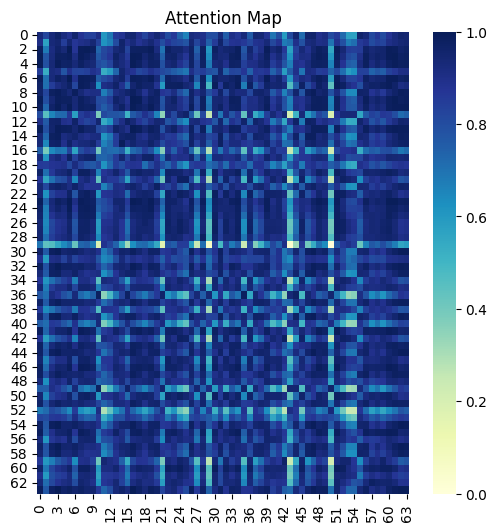

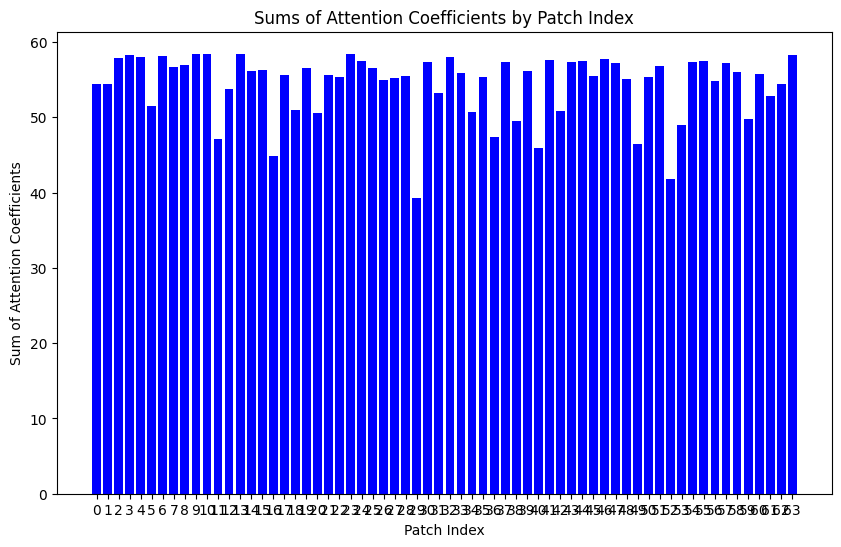

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 20%|██        | 10/50 [4:36:26<19:17:08, 1735.72s/it]

torch.Size([240, 64, 16])
Row sums: [54.40977  54.65058  57.965996 58.398033 57.991657 51.419586 58.114994
 56.369465 56.967735 58.35768  58.432823 46.800747 53.986256 58.45867
 56.12727  56.233147 44.657562 55.491276 51.03384  56.466454 50.442375
 55.719368 55.50922  58.506554 57.45182  56.407677 54.72312  55.060795
 55.599365 38.97741  57.425743 53.24774  58.114716 55.93156  50.903732
 55.550568 47.94703  57.53323  49.757538 56.25846  46.777115 57.79875
 50.95215  57.450417 57.596893 55.639168 57.644047 57.401768 54.968002
 47.41694  55.682343 56.97283  42.501976 49.366455 57.564457 57.577778
 54.642418 57.06482  55.71243  50.011696 55.84709  53.23504  54.658695
 58.19249 ]


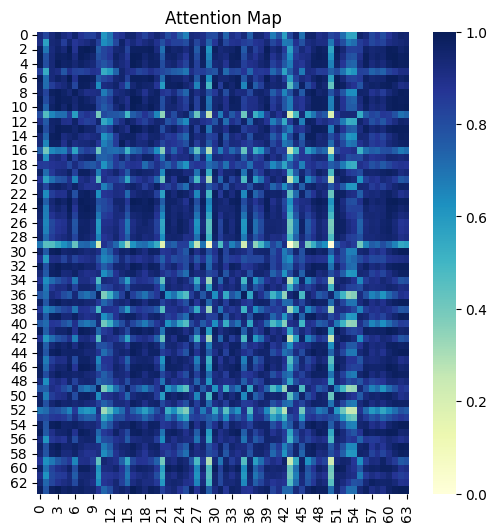

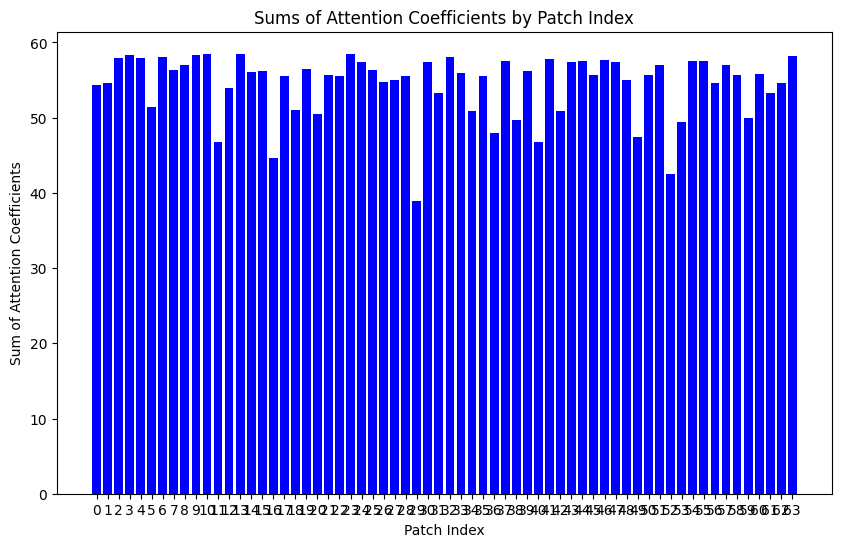

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 22%|██▏       | 11/50 [5:05:26<18:49:01, 1736.95s/it]

torch.Size([240, 64, 16])
Row sums: [54.36207  54.783546 57.99238  58.429913 57.982452 51.331158 58.00891
 56.072964 56.941498 58.326126 58.41158  46.390858 54.134453 58.444077
 56.149918 56.213795 44.38598  55.364967 51.022057 56.341103 50.273575
 55.75754  55.67375  58.536354 57.393204 56.256256 54.37187  54.791298
 55.64144  38.61187  57.41474  53.1772   58.214012 55.943962 51.110115
 55.702744 48.561596 57.68877  49.94151  56.285686 47.609467 57.887985
 51.016552 57.47396  57.708008 55.802704 57.57854  57.548904 54.780968
 48.37121  55.928284 57.05046  43.230736 49.72124  57.702705 57.63195
 54.427155 56.948883 55.40744  50.250732 55.934937 53.53163  54.8256
 58.11812 ]


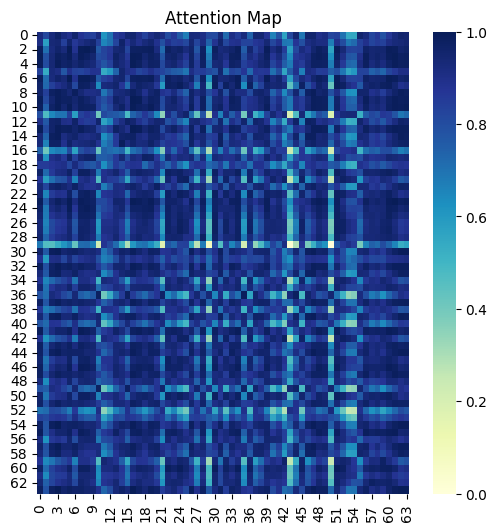

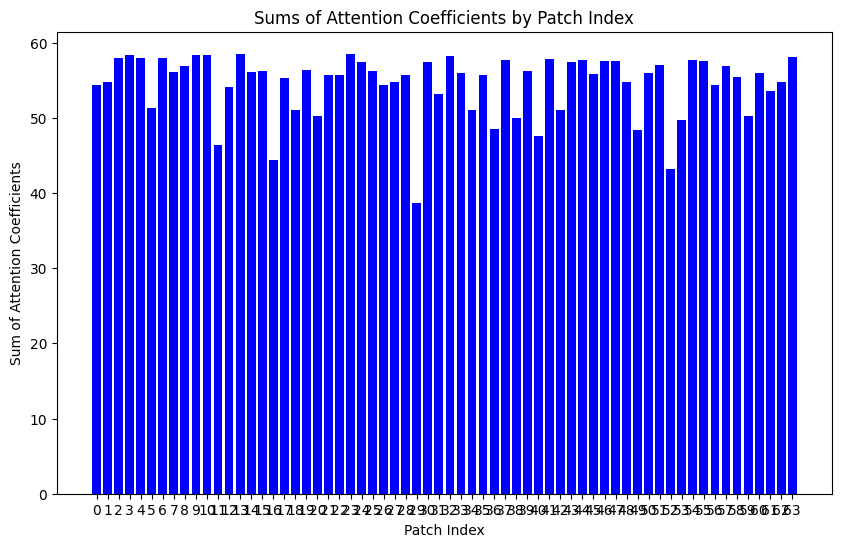

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 24%|██▍       | 12/50 [5:34:19<18:19:17, 1735.72s/it]

torch.Size([240, 64, 16])
Row sums: [54.28592  54.850235 57.985172 58.421276 57.943604 51.218124 57.84759
 55.72283  56.878975 58.254284 58.360275 45.932007 54.25119  58.39953
 56.150513 56.15583  44.05761  55.190887 50.978447 56.159172 50.079727
 55.769127 55.789497 58.52832  57.291634 56.054115 53.96143  54.47757
 55.663483 38.236107 57.37245  53.065895 58.262825 55.978996 51.26579
 55.811256 49.158302 57.800156 50.036148 56.28298  48.368195 57.93433
 51.02218  57.462242 57.78739  55.928383 57.4889   57.646954 54.525635
 49.253475 56.12935  57.09822  43.91118  50.022167 57.80484  57.648483
 54.163567 56.797817 55.064228 50.400833 55.97261  53.767532 54.954056
 58.00772 ]


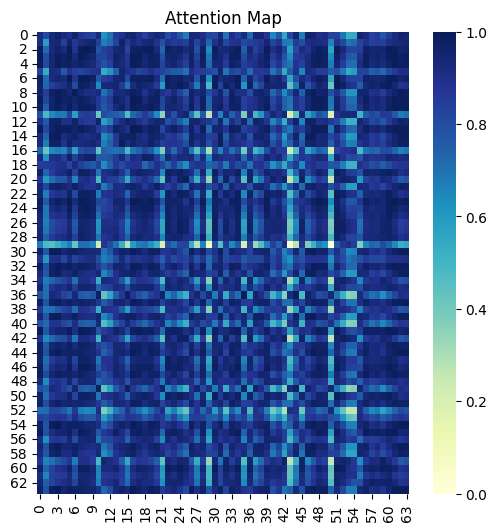

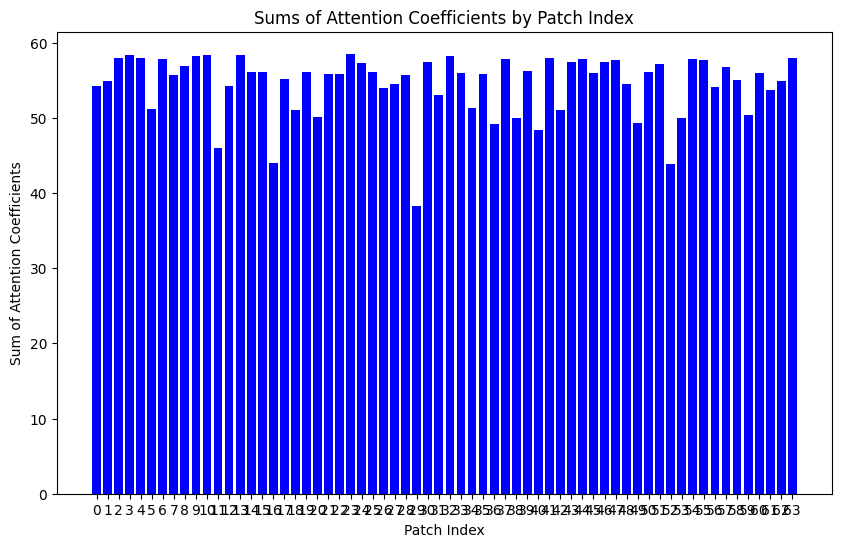

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 26%|██▌       | 13/50 [6:03:24<17:52:02, 1738.44s/it]

torch.Size([240, 64, 16])
Row sums: [54.19551  54.863518 57.95735  58.387436 57.887455 51.098793 57.64216
 55.33087  56.79447  58.15514  58.2912   45.44541  54.351234 58.337196
 56.147972 56.07303  43.69558  54.982315 50.919373 55.934998 49.871376
 55.7641   55.878323 58.496025 57.158516 55.813866 53.50724  54.13262
 55.66601  37.852215 57.31265  52.92839  58.272224 56.047462 51.388397
 55.89     49.75638  57.8787   50.077515 56.26459  49.074905 57.953136
 50.987167 57.428772 57.83606  56.0291   57.385212 57.70485  54.217903
 50.07938  56.300716 57.127808 44.564293 50.295834 57.877193 57.641888
 53.867256 56.624695 54.694855 50.490826 55.979504 53.962234 55.058163
 57.87401 ]


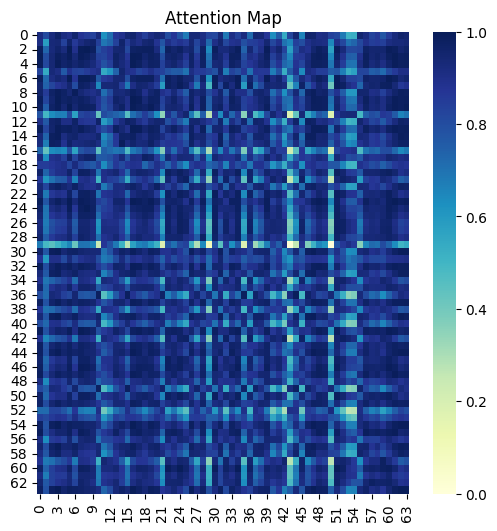

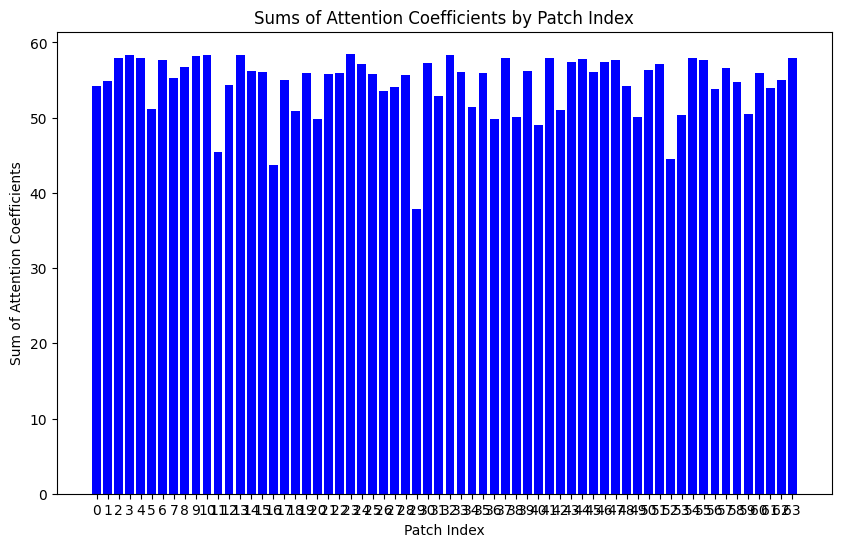

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 28%|██▊       | 14/50 [6:32:31<17:24:43, 1741.21s/it]

torch.Size([240, 64, 16])
Row sums: [54.102417 54.833572 57.919582 58.34188  57.82437  50.987064 57.398994
 54.909935 56.69989  58.040195 58.21517  44.947685 54.44624  58.267365
 56.159203 55.976765 43.31753  54.750507 50.856045 55.6812   49.655556
 55.747463 55.957504 58.451057 57.003937 55.54678  53.02574  53.76319
 55.644302 37.4651   57.247776 52.77566  58.250973 56.151127 51.490616
 55.95012  50.36316  57.933666 50.108994 56.24217  49.7448   57.957096
 50.929443 57.384964 57.848564 56.115158 57.274967 57.729477 53.87062
 50.857895 56.453293 57.146935 45.210068 50.562534 57.92237  57.62364
 53.550076 56.44348  54.3096   50.551838 55.977062 54.131447 55.14805
 57.72831 ]


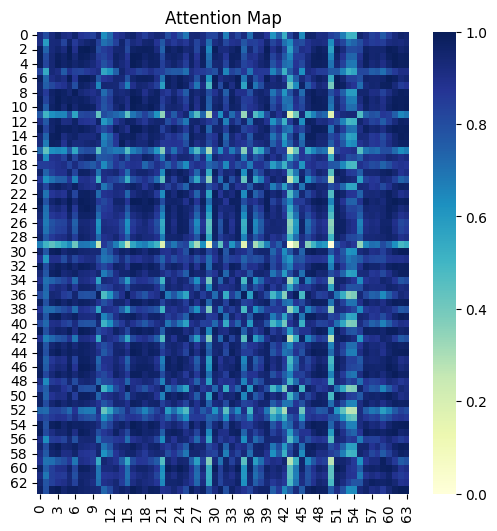

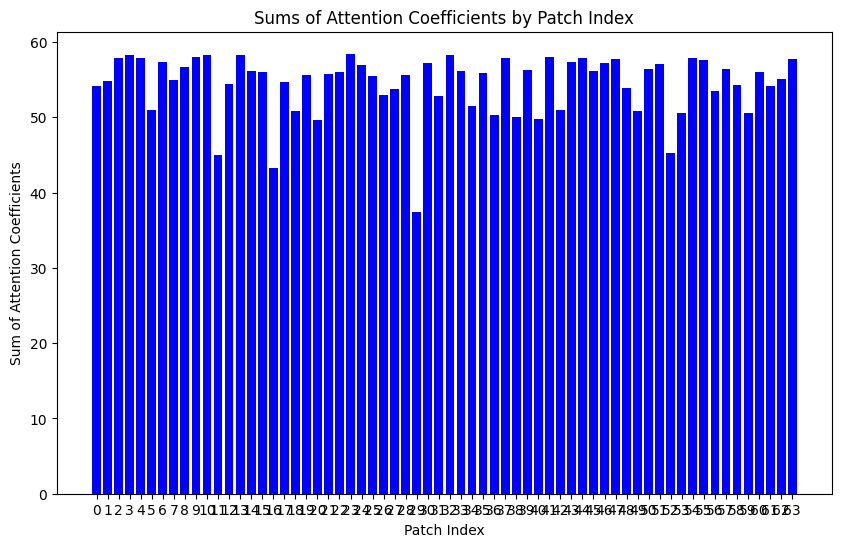

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 30%|███       | 15/50 [7:01:20<16:53:34, 1737.55s/it]

torch.Size([240, 64, 16])
Row sums: [54.006477 54.758183 57.87113  58.285503 57.754387 50.88558  57.116096
 54.459045 56.595238 57.909946 58.132214 44.436264 54.533745 58.190285
 56.181255 55.86724  42.9244   54.49508  50.78708  55.39574  49.42639
 55.720066 56.024975 58.394005 56.82632  55.251575 52.51491  53.368584
 55.598873 37.072334 57.17758  52.606453 58.196453 56.274536 51.572994
 55.992252 50.968887 57.96337  50.12774  56.21711  50.375816 57.946182
 50.846306 57.331146 57.82598  56.185776 57.156128 57.716778 53.482693
 51.586662 56.58653  57.153847 45.84063  50.808487 57.936558 57.593014
 53.210094 56.25423  53.910984 50.579514 55.965168 54.27562  55.222557
 57.571   ]


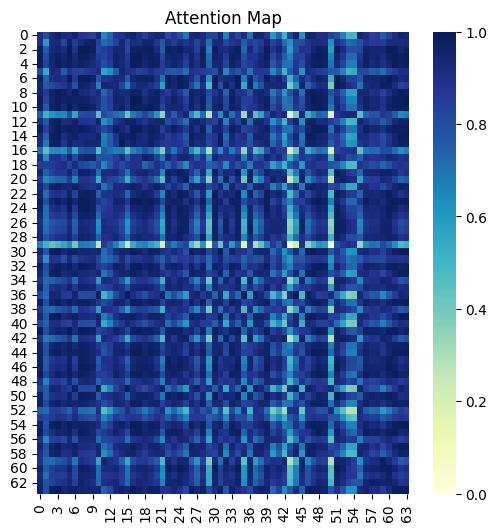

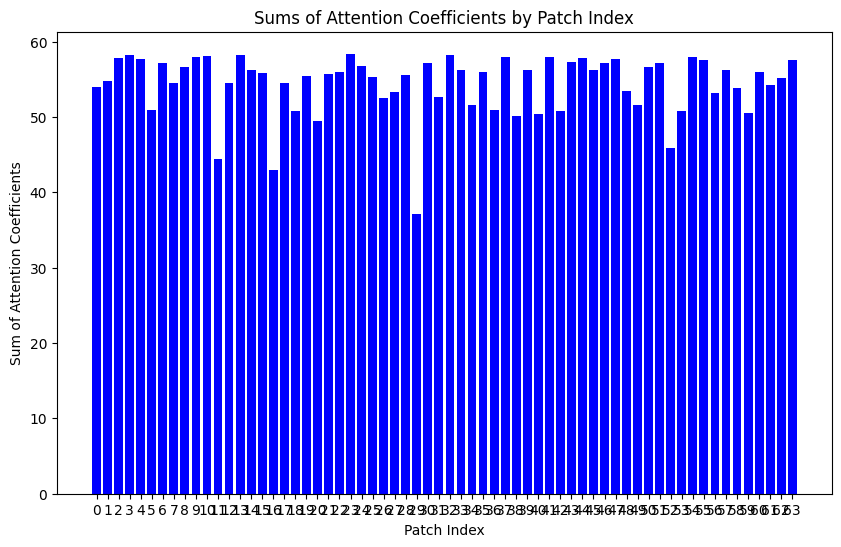

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 32%|███▏      | 16/50 [7:30:39<16:28:12, 1743.89s/it]

torch.Size([240, 64, 16])
Row sums: [53.91371  54.640465 57.815216 58.221596 57.681732 50.80226  56.801758
 53.98358  56.484352 57.76857  58.046013 43.921482 54.61329  58.11003
 56.212494 55.749363 42.530083 54.223267 50.720604 55.0819   49.18873
 55.692253 56.081257 58.328865 56.628242 54.932465 51.979904 52.970097
 55.54708  36.701546 57.10531  52.42662  58.109795 56.405754 51.644424
 56.022537 51.57173  57.969112 50.12814  56.19608  50.970783 57.92372
 50.73912  57.271687 57.783314 56.244873 57.031677 57.66703  53.059135
 52.269238 56.703873 57.151466 46.44686  51.013367 57.926044 57.553734
 52.852203 56.06113  53.50876  50.567085 55.939415 54.39977  55.28789
 57.406227]


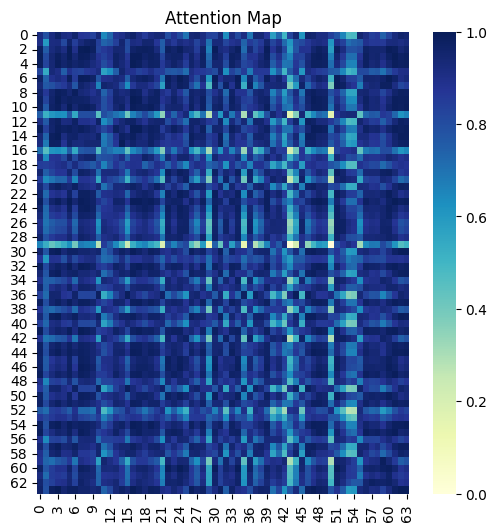

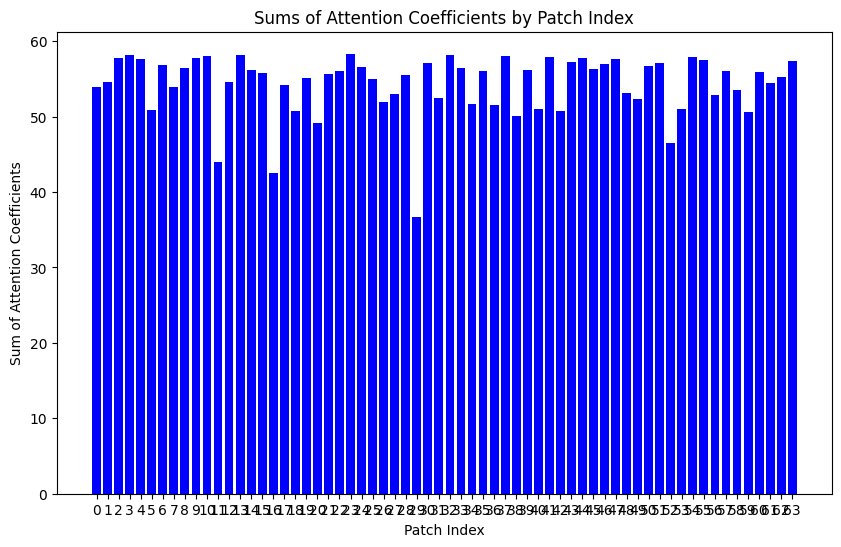

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 34%|███▍      | 17/50 [7:59:34<15:57:43, 1741.31s/it]

torch.Size([240, 64, 16])


: 

: 

In [14]:
for iepoch in tqdm(range(50)):
    optimizer.zero_grad()
    X_tensor=torch.tensor(X_train)
    predictions=model(X_tensor.float()).squeeze(1)
    #predictions=torch.sign(predictions)
    #print(predictions)
    label=torch.tensor(y_train)
    #for i in range(len(label)):
    #    if label[i]==1:
    #        label[i] = 0
    #    else:
    #        label[i]=1
    #print(label)
    loss = criterion(predictions, label.float())
    acc = multi_accuracy(predictions, label)
    print('')
    print('Accuracy:',acc)
    print('')
    print(loss)
    loss.backward()
    optimizer.step()

In [16]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [27]:
# 학습 후 모델 파라미터 저장 경로
model_save_path = "/home/jaeyeob/QVT/result/CIFAR10/qsann_classifier_1.pth"

In [28]:
# Attention value extraction (after forward pass, assuming attention is part of the output)
class AttentionExtractor(QSANN_text_classifier):
    def __init__(self, S, n, Denc, D, num_layers):
        super().__init__(S, n, Denc, D, num_layers)
        self.attention_values = None

    def forward(self, input):
        x = self.Qnn(input)
        x = torch.flatten(x, start_dim=1)
        
        # Extract attention values from the QSAL layers (assuming alpha in the QSAL_pennylane)
        self.attention_values = self.Qnn.qsal_lst[0].alpha  # Example for first QSAL layer
        output = torch.sigmoid(self.final_layer(x))
        return output


In [29]:
# Create an instance of the new model with attention extraction
attention_model = AttentionExtractor(64, 4, 2, 1, 1)
attention_model.load_state_dict(torch.load(model_save_path))
attention_model.eval()

AttentionExtractor(
  (Qnn): QSANN_pennylane(
    (qnn): Sequential(
      (0): QSAL_pennylane()
    )
  )
  (final_layer): Linear(in_features=1024, out_features=1, bias=True)
)

In [30]:
# # Training the model
# for iepoch in tqdm(range(30)):
#     optimizer.zero_grad()
#     X_tensor = torch.tensor(X_train)
#     predictions = model(X_tensor.float()).squeeze(1)
    
#     label = torch.tensor(y_train)
#     for i in range(len(label)):
#         label[i] = 0 if label[i] == 1 else 1
    
#     loss = criterion(predictions, label.float())
#     acc = binary_accuracy(predictions, label)
#     print(f'Accuracy: {acc}')
#     print(f'Loss: {loss}')
    
#     loss.backward()
#     optimizer.step()
#     print(f"Complete {iepoch} th")

# # Save the model parameters
# torch.save(model.state_dict(), model_save_path)
# print("Model parameters saved.")

Row sums: [54.11699  56.878517 43.35569  56.913185 55.968674 35.168243 54.307762
 48.510445 55.78875  51.240906 52.733814 49.403328 57.427116 51.244587
 57.29963  54.930862 51.178837 52.273533 53.392807 55.21904  49.06929
 53.656677 56.861076 53.735203 36.109394 57.28287  54.76024  54.20981
 56.906754 47.749794 55.34877  53.009857 55.21425  53.614975 55.701614
 54.482384 41.28666  51.640495 37.764496 55.664036 56.97918  57.06447
 51.871452 54.688656 44.649097 54.94396  55.760544 57.082935 57.028877
 50.91393  54.085045 55.48645  56.92231  55.1949   57.25741  56.991203
 46.40087  52.99317  55.702488 55.967457 48.267536 49.696747 31.638039
 53.93479 ]


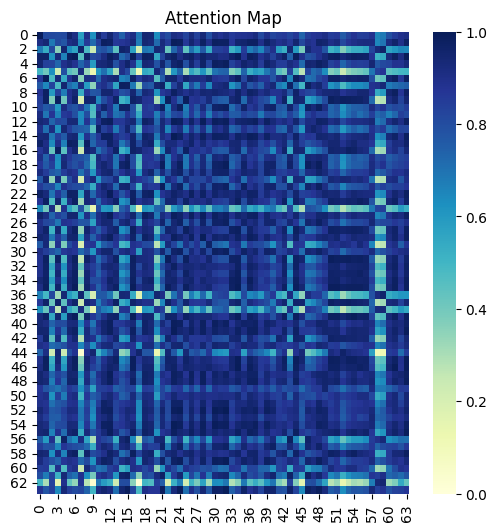

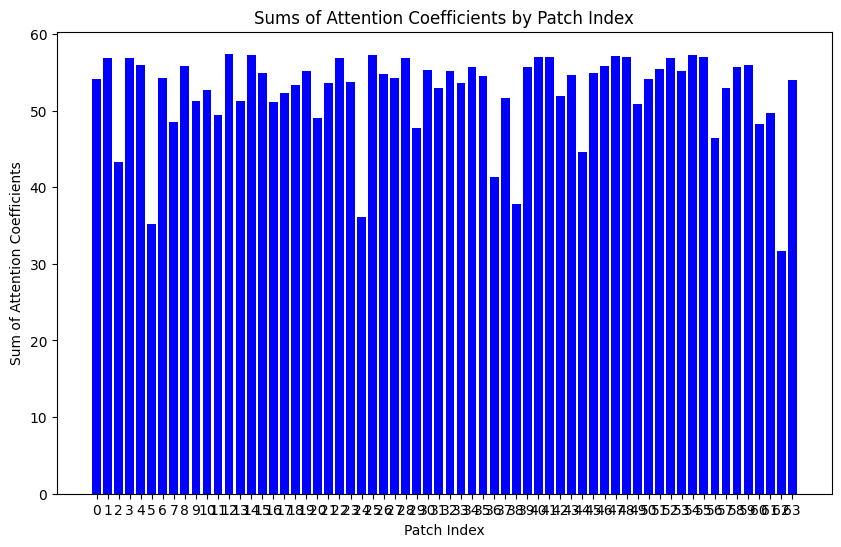


Accuracy: 0.8999999761581421

Loss: 68.84530639648438

AUROC: 0.9625

Precision: 0.9

Recall: 0.9

F1 Score: 0.9

AUPRC: 0.9554093648962576



/tmp/ipykernel_308884/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


In [31]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, average_precision_score

# Convert test data to tensor
X_tensor = torch.tensor(X_test)
predictions = attention_model(X_tensor.float()).squeeze(1)
label = torch.tensor(y_test)

# Reverse the labels (if needed)
for i in range(len(label)):
    if label[i] == 1:
        label[i] = 0
    else:
        label[i] = 1

# Calculate loss and accuracy
loss = criterion(predictions, label.float())
acc = binary_accuracy(predictions, label.float())

# Convert predictions and labels to numpy for sklearn metrics
preds_np = predictions.detach().numpy()  # Detach predictions from the graph and convert to numpy
labels_np = label.numpy()  # Convert labels to numpy

# Calculate AUROC
auroc = roc_auc_score(labels_np, preds_np)

# Binarize predictions for precision, recall, and F1 calculation
binary_preds = np.where(preds_np > 0.5, 1, 0)

# Calculate Precision, Recall, and F1 Score
precision, recall, f1, _ = precision_recall_fscore_support(labels_np, binary_preds, average='binary')

# Calculate AUPRC (Area Under the Precision-Recall Curve)
auprc = average_precision_score(labels_np, preds_np)

# Print results
print(f'\nAccuracy: {acc}\n')
print(f'Loss: {loss}\n')
print(f'AUROC: {auroc}\n')
print(f'Precision: {precision}\n')
print(f'Recall: {recall}\n')
print(f'F1 Score: {f1}\n')
print(f'AUPRC: {auprc}\n')


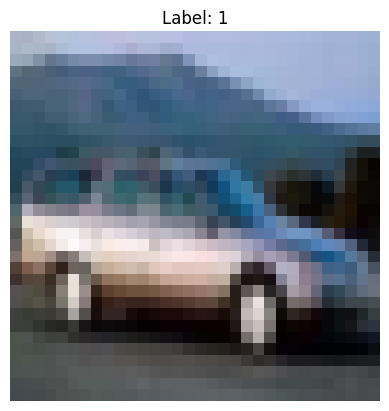

In [29]:
import tensorflow as tf
import matplotlib.pyplot as plt

# CIFAR-10 데이터셋 로드
cifar10 = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# 첫 번째 샘플 추출
image = train_images[4]

# 이미지 시각화
plt.imshow(image)
plt.title(f'Label: {train_labels[4][0]}')
plt.axis('off')
plt.show()


In [30]:
image_gray = np.dot(image[...,:3], [0.299, 0.587, 0.114])
single = np.array([split_into_non_overlapping_patches(image_gray)])

In [31]:
single

array([[[179.062, 177.062, 184.66 , ...,  98.915, 100.083,  93.169],
        [194.023, 192.468, 194.006, ...,  95.287,  95.238,  94.928],
        [193.463, 192.762, 195.039, ...,  91.069,  98.792, 102.526],
        ...,
        [ 57.854,  44.854,  49.082, ...,  91.961,  87.548,  84.124],
        [ 28.869,  28.755,  26.858, ...,  78.124,  78.548,  75.146],
        [ 23.445,  26.146,  28.146, ...,  78.146,  74.146,  76.146]]])

In [32]:
single_sample = torch.tensor(single.astype(np.float32))  # Select one sample

In [33]:
# Attention value extraction (after forward pass, assuming attention is part of the output)
class AttentionExtractor(QSANN_text_classifier):
    def __init__(self, S, n, Denc, D, num_layers):
        super().__init__(S, n, Denc, D, num_layers)
        self.attention_values = None

    def forward(self, input):
        x = self.Qnn(input)
        x = torch.flatten(x, start_dim=1)
        
        # Extract attention values from the QSAL layers (assuming alpha in the QSAL_pennylane)
        self.attention_values = self.Qnn.qsal_lst[0].alpha  # Example for first QSAL layer
        output = torch.sigmoid(self.final_layer(x))
        return output


In [34]:
# Create an instance of the new model with attention extraction
attention_model = AttentionExtractor(64, 4, 2, 1, 1)
attention_model.load_state_dict(torch.load(model_save_path))
attention_model.eval()

AttentionExtractor(
  (Qnn): QSANN_pennylane(
    (qnn): Sequential(
      (0): QSAL_pennylane()
    )
  )
  (final_layer): Linear(in_features=1024, out_features=1, bias=True)
)

Row sums: [58.063984 59.032066 59.03582  59.017338 57.32975  46.169643 46.861065
 57.99359  58.530388 55.853123 57.24405  59.015244 58.757797 57.89521
 58.031208 53.21495  56.294098 59.03276  41.93651  57.794792 58.947304
 51.86485  55.909496 49.107193 57.081688 58.942497 58.872932 56.888847
 58.687542 53.02982  57.938908 44.345905 55.55957  48.011303 55.104053
 59.01985  59.016228 58.261063 58.81405  59.035725 58.967293 58.558296
 58.699913 56.319786 55.409805 43.420235 58.356987 52.373383 50.236298
 52.02114  58.777344 52.491394 58.941856 56.457733 58.637802 52.067383
 56.77289  56.96529  58.363358 45.35786  57.029922 56.30916  53.03
 47.428307]


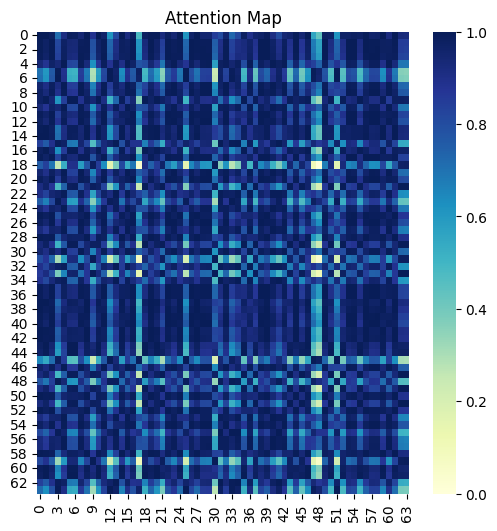

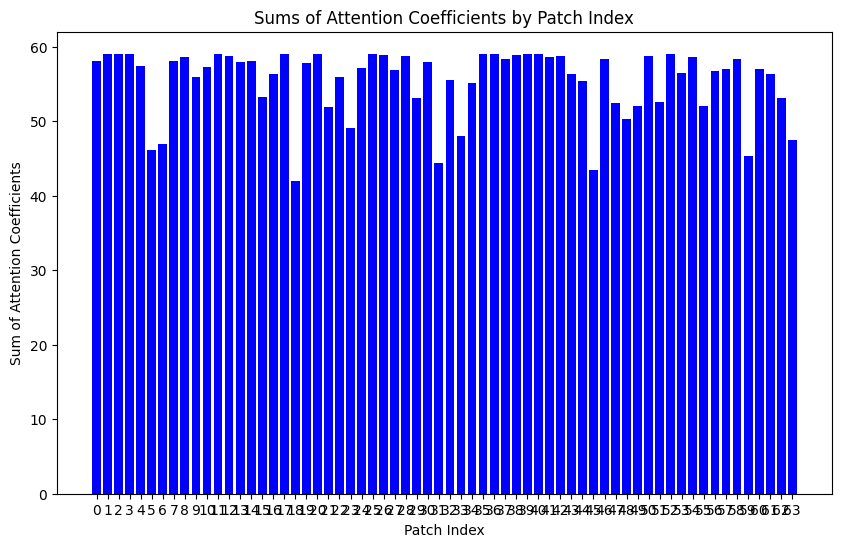

Predicted class for the sample: 1.0
Row sums: [58.063984 59.032066 59.03582  59.017338 57.32975  46.169643 46.861065
 57.99359  58.530388 55.853123 57.24405  59.015244 58.757797 57.89521
 58.031208 53.21495  56.294098 59.03276  41.93651  57.794792 58.947304
 51.86485  55.909496 49.107193 57.081688 58.942497 58.872932 56.888847
 58.687542 53.02982  57.938908 44.345905 55.55957  48.011303 55.104053
 59.01985  59.016228 58.261063 58.81405  59.035725 58.967293 58.558296
 58.699913 56.319786 55.409805 43.420235 58.356987 52.373383 50.236298
 52.02114  58.777344 52.491394 58.941856 56.457733 58.637802 52.067383
 56.77289  56.96529  58.363358 45.35786  57.029922 56.30916  53.03
 47.428307]


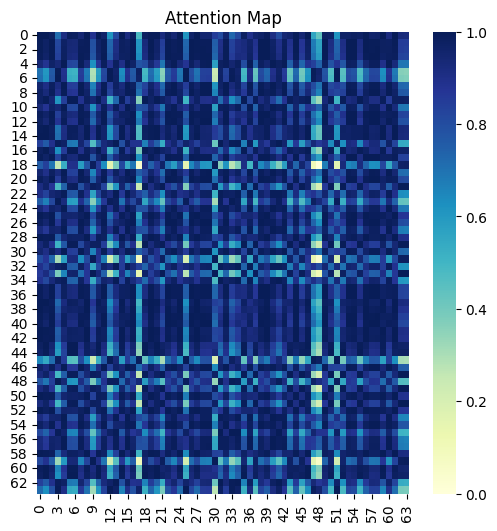

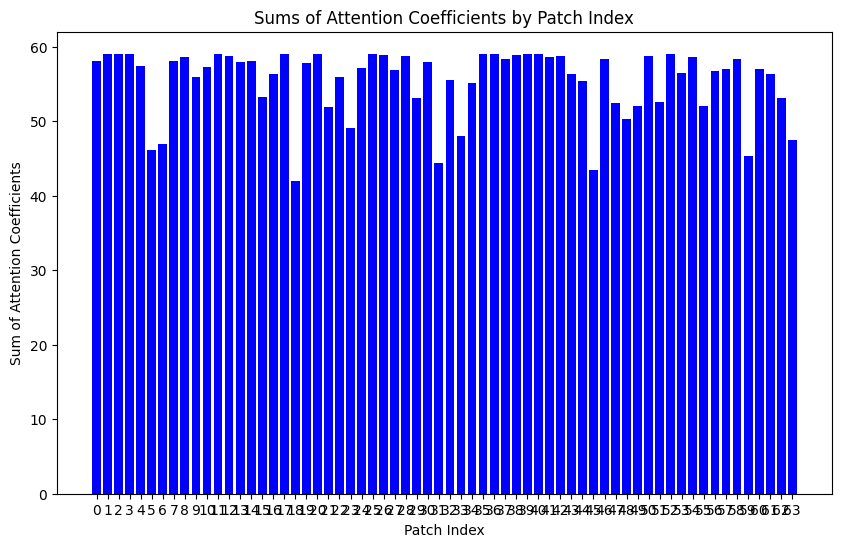

Extracted attention values: tensor([[[0.9977, 0.9988, 0.9877,  ..., 0.9987, 0.9493, 0.9467],
         [0.9968, 0.9808, 1.0000,  ..., 0.9952, 0.8950, 0.8914],
         [0.9960, 0.9791, 1.0000,  ..., 0.9943, 0.8912, 0.8875],
         ...,
         [0.9846, 0.9982, 0.9654,  ..., 0.9875, 0.9773, 0.9755],
         [0.8865, 0.8317, 0.9225,  ..., 0.8786, 0.6781, 0.6730],
         [0.8057, 0.7415, 0.8510,  ..., 0.7962, 0.5775, 0.5724]]])


In [35]:
# Make a prediction for the single sample
# Get the attention values for a single sample
with torch.no_grad():
    prediction = attention_model(single_sample).squeeze()
    predicted_class = (torch.round(prediction)).item()
    print(f"Predicted class for the sample: {predicted_class}")

    _ = attention_model(single_sample)  # Forward pass to calculate attention
    attention_values = attention_model.attention_values  # Extracted attention values
    print(f"Extracted attention values: {attention_values}")

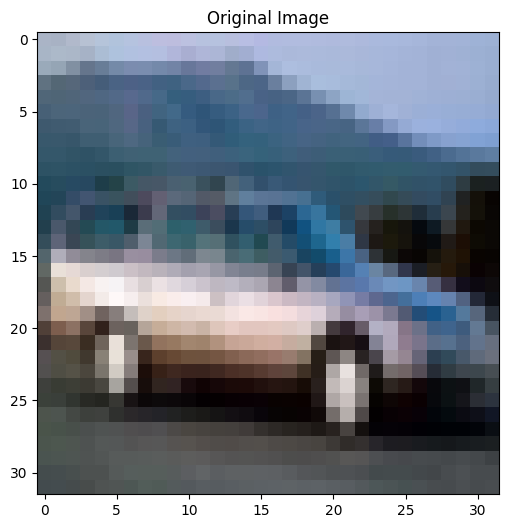

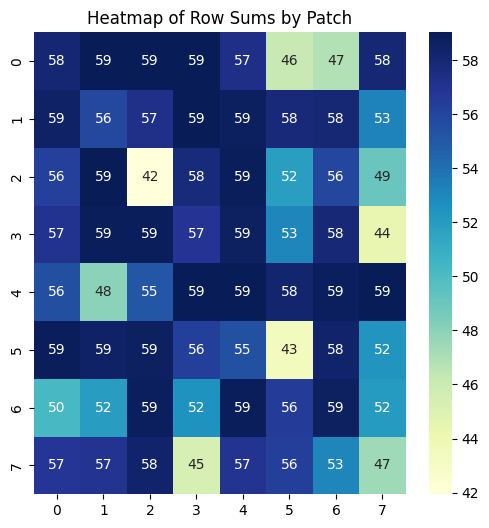

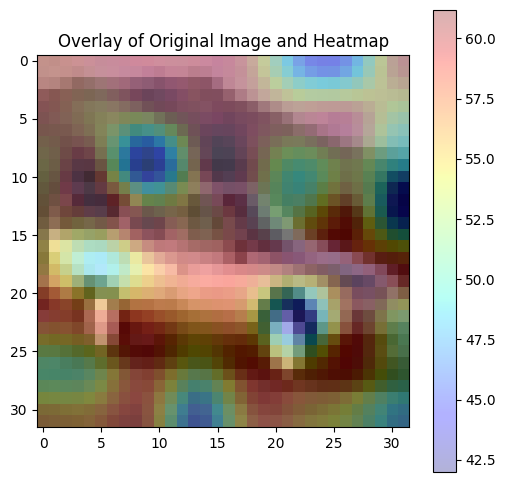

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

def visualize_sample_and_heatmap(sample, row_sums, patch_shape=(8, 8)):
    """
    sample: The original image (2D numpy array)
    row_sums: The sums corresponding to each patch
    patch_shape: Shape of the patch grid (e.g., (2, 2))
    """
    # 1. Plot the original sample image
    plt.figure(figsize=(6, 6))
    plt.imshow(sample, cmap='gray', interpolation='none')
    plt.title("Original Image")
    plt.show()

    # 2. Create the heatmap using the row sums
    heatmap_values = np.array(row_sums).reshape(patch_shape)

    plt.figure(figsize=(6, 6))
    sns.heatmap(heatmap_values, annot=True, cmap="YlGnBu", cbar=True)
    plt.title("Heatmap of Row Sums by Patch")
    plt.show()

    # 3. Resize the heatmap to match the sample size
    from scipy.ndimage import zoom
    resized_heatmap = zoom(heatmap_values, (sample.shape[0] / patch_shape[0], sample.shape[1] / patch_shape[1]))

    # Overlay the heatmap on the original image
    plt.figure(figsize=(6, 6))
    plt.imshow(sample, cmap='gray', interpolation='none')
    plt.imshow(resized_heatmap, cmap='jet', alpha=0.3, interpolation='none')
    plt.colorbar()
    plt.title("Overlay of Original Image and Heatmap")
    plt.show()

# Example usage
# Select a single sample from the test set
single_sample = torch.tensor(single.astype(np.float32))  # Select one sample

# Reshape the single sample back to its 2D form for visualization (assuming it's 8x8 based on CIFAR-10 patching)
original_image = image

# Example row sums based on output
row_sums =[58.063984, 59.032066, 59.03582, 59.017338, 57.32975, 46.169643, 46.861065, 57.99359, 58.530388, 55.853123, 57.24405, 59.015244, 58.757797, 57.89521, 58.031208, 53.21495, 56.294098, 59.03276, 41.93651, 57.794792, 58.947304, 51.86485, 55.909496, 49.107193, 57.081688, 58.942497, 58.872932, 56.888847, 58.687542, 53.02982, 57.938908, 44.345905, 55.55957, 48.011303, 55.104053, 59.01985, 59.016228, 58.261063, 58.81405, 59.035725, 58.967293, 58.558296, 58.699913, 56.319786, 55.409805, 43.420235, 58.356987, 52.373383, 50.236298, 52.02114, 58.777344, 52.491394, 58.941856, 56.457733, 58.637802, 52.067383, 56.77289, 56.96529, 58.363358, 45.35786, 57.029922, 56.30916, 53.03, 47.428307]



# Visualize the sample and the heatmap
visualize_sample_and_heatmap(original_image, row_sums, patch_shape=(8, 8))


-----------------------------------------